# 重み初期化

In [15]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import init
from torch.nn import functional as F
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

## ハンズオン

In [2]:
# 勾配消失
X = torch.randn(60, 30)

for i in range(50):  # 数字を上げていくと結果さらに大きくなっていく
    W = torch.randn(30, 30) *0.01  #重みが小さいと今度は消失する
    X = X @ W.T

# 重みに小さい値をかけると0になる
X[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [3]:
# 勾配爆発
X = torch.randn(60, 30)

for i in range(50):  # 数字を上げていくと結果さらに大きくなっていく
    W = torch.randn(30, 30) #*0.01  #重みが小さいと今度は消失する
    X = X @ W.T

# かなり大きい数値になる
# Wを何回もかけていくと、値が大きくなり発散していく
X[0]

tensor([-3.2596e+36, -1.0145e+37, -1.3684e+36, -1.6779e+36, -8.3866e+36,
         3.1403e+36,  1.7761e+37,  1.6401e+37, -7.6075e+36, -2.1595e+37,
        -1.3821e+35,  4.4054e+36, -6.3580e+36,  5.1340e+36, -1.5784e+37,
        -7.0757e+36, -1.8157e+37, -9.7440e+36,  8.4412e+36,  9.7550e+36,
        -1.3184e+37,  7.4934e+36,  3.1144e+36,  1.9205e+37, -1.5269e+37,
        -9.5401e+36,  9.4476e+36,  1.2434e+37, -2.2584e+37,  6.4674e+36])

## Xavier初期化とKaiming初期化

- Xavier初期化およびKaiming初期化をした重み行列を複数回順伝播しても、出力が消失/爆発しないことを確認する
- 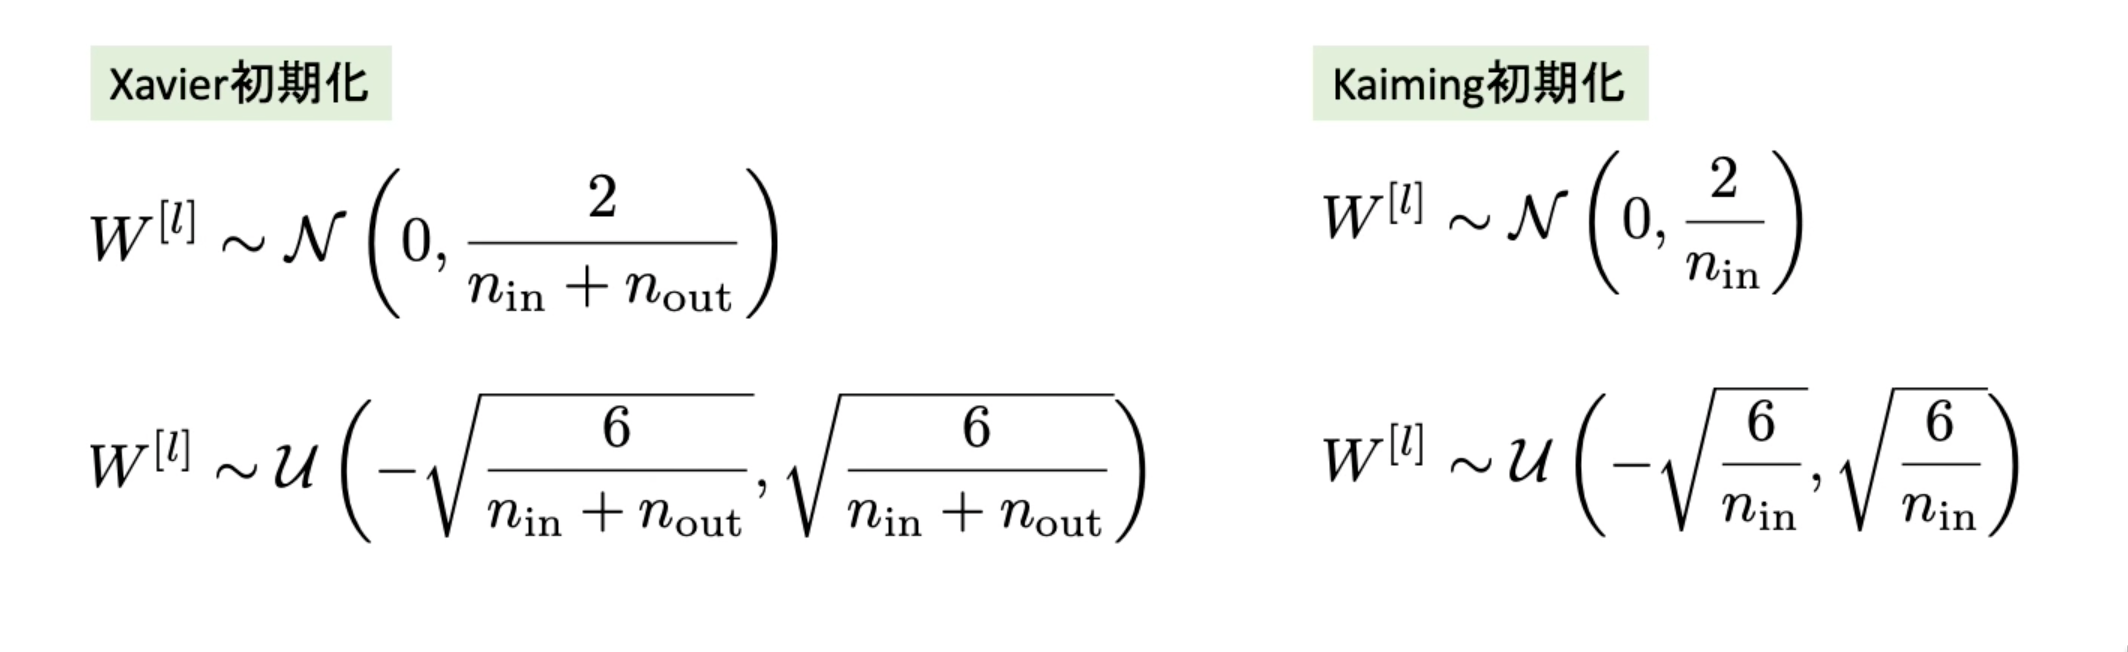

### Xavier初期化

In [4]:
X = torch.randn(60, 30)
n_out, n_in = 30, 30

# 正規分布: N(0, 2/(n_in+n_out))
std = torch.sqrt(torch.tensor(2. / (n_in + n_out)))
# 一様分布: u(-sqrt(6/(n_in+n_out)), sqrt(6/(n_in+n_out)))
limit = torch.sqrt(torch.tensor(6. / (n_in + n_out)))

for i in range(50):
    # 正規分布
    W_n = torch.randn(n_out, n_in) * std
    X_n = X @ W_n.T
    # 一様分布
    W_u = torch.randn(n_out, n_in)*2*limit - limit
    X_u = X @ W_u.T

print(f'正規分布　平均: {X_n.mean()}, 標準偏差: {X_n.std()}')
print(X_n)
print(f'一様分布　平均: {X_u.mean()}, 標準偏差: {X_u.std()}')
print(X_u)

正規分布　平均: 0.02050919085741043, 標準偏差: 1.0039926767349243
tensor([[ 1.8697, -0.7526,  1.1394,  ...,  1.8593, -0.8488,  0.0477],
        [-0.0561, -1.3502, -0.7327,  ..., -2.0010,  0.7284,  0.6486],
        [ 0.3070, -0.7246, -1.3475,  ..., -0.8736, -1.7465, -0.4354],
        ...,
        [-1.0622,  1.7296, -0.8352,  ..., -0.5032,  0.6583,  0.2797],
        [-0.3651, -0.3608, -1.7132,  ..., -2.1697,  0.3851, -0.2722],
        [-0.9172,  0.8203,  0.5371,  ...,  0.2238,  2.2404, -0.7022]])
一様分布　平均: -0.17915405333042145, 標準偏差: 3.7373833656311035
tensor([[ 3.1122, -0.8496,  1.9203,  ...,  3.9568, -3.7627, -6.3328],
        [ 3.7267,  0.8805, -1.3021,  ..., -7.9507,  0.4747,  0.2977],
        [-3.1779, -3.9796,  1.7727,  ...,  1.9484,  1.6003,  0.1511],
        ...,
        [-4.0014, -3.3021, -8.3298,  ..., -1.6781, -1.7613, -2.6882],
        [ 0.8914,  6.4802,  3.1046,  ...,  3.0646,  4.0433, -0.3488],
        [-5.0684,  1.5026, -0.0849,  ...,  0.7677, -6.7268, -0.3579]])


### Kaiming初期化

In [5]:
X = torch.randn(60, 30)
n_out, n_in = 30, 30

# 正規分布: N(0, 2/(n_in))
std = torch.sqrt(torch.tensor(2. / n_in))
# 一様分布: u(-sqrt(6/n_in), sqrt(6/n_in))
limit = torch.sqrt(torch.tensor(6. / n_in))

for i in range(50):
    # 正規分布
    W_n = torch.randn(n_out, n_in) * std
    X_n = X @ W_n.T
    X_n = torch.clamp(X_n, min=0.)  # ReLU
    # 一様分布
    W_u = torch.randn(n_out, n_in)*2*limit - limit
    X_u = X @ W_u.T
    X_u = torch.clamp(X_u, min=0.)  # ReLU

print(f'正規分布　平均: {X_n.mean()}, 標準偏差: {X_n.std()}')
print(X_n)
print(f'一様分布　平均: {X_u.mean()}, 標準偏差: {X_u.std()}')
print(X_u)

正規分布　平均: 0.5665792226791382, 標準偏差: 0.86892169713974
tensor([[2.8937, 0.3613, 0.0000,  ..., 3.8529, 0.1077, 0.0000],
        [0.0000, 0.0000, 2.7184,  ..., 0.0000, 2.1319, 0.5359],
        [2.5712, 0.0000, 4.0209,  ..., 0.0000, 0.1243, 0.6680],
        ...,
        [2.2837, 0.6129, 0.0000,  ..., 2.0417, 0.0000, 1.6132],
        [2.2964, 0.3416, 0.8560,  ..., 1.3422, 0.7497, 1.6964],
        [0.0000, 0.0000, 0.1969,  ..., 0.0000, 0.0000, 1.7746]])
一様分布　平均: 1.9855549335479736, 標準偏差: 3.0229427814483643
tensor([[ 3.3959,  0.0000,  6.9978,  ...,  2.0397,  0.6728,  0.0000],
        [ 7.4581,  0.0563, 12.7679,  ...,  6.1594,  1.6642,  2.1653],
        [ 4.7892,  0.4572,  1.4934,  ..., 15.7324,  2.8377, 14.9939],
        ...,
        [ 5.3315,  3.9677,  4.2654,  ...,  0.0000,  0.0000,  2.7571],
        [ 0.0000,  6.5140,  0.0000,  ...,  3.5505,  7.8490,  5.3680],
        [ 0.7540,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## PytorchでKaiming初期化を実施する

- torch.nn.init.kaiming_normal_()関数を使って、対象の層の重みを初期化する
    - tensor: 初期化対象となる重み(layer.weight)
- 学習前nomodelをいてレーションし、それぞれの層を初期化する
    - 実行する際に、nn.Linearやnn.Conv2dなど層を指定して初期化する
- nn.Linearとnn.Conv2dのデフォルトの重みの初期値は以下の通り
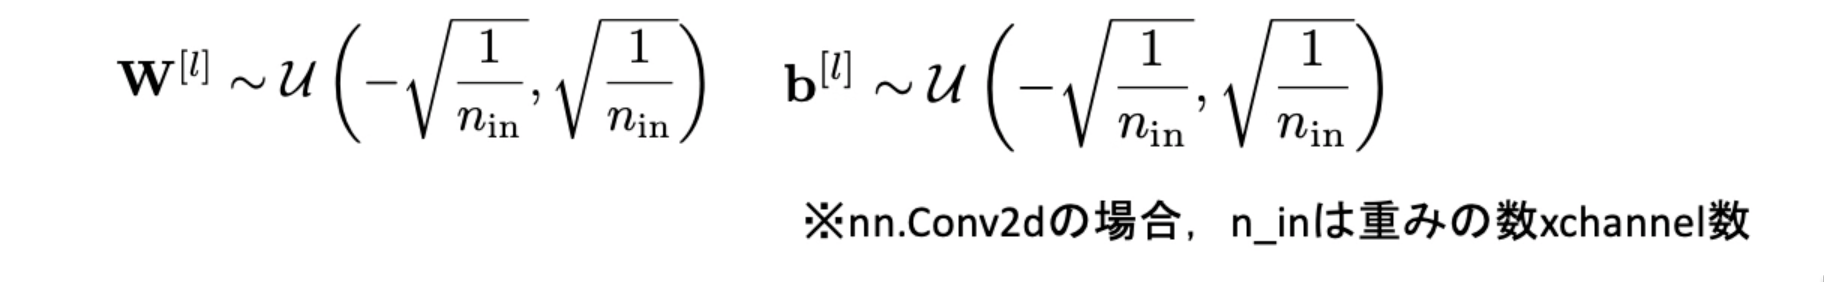

In [12]:
# CNNモデル作成
conv = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
print(conv.weight.mean(), conv.weight.std()) # default std= np.sqrt(1/3*n_in*k*k)

# Kaiming初期化（Normal:正規分布）
init.kaiming_normal_(conv.weight)
print(conv.weight.mean(), conv.weight.std()) # kaiming std= np.sqrt(2/n_in*k*k)

tensor(-0.0054, grad_fn=<MeanBackward0>) tensor(0.1989, grad_fn=<StdBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>) tensor(0.5057, grad_fn=<StdBackward0>)


In [10]:
# 標準偏差が sqrt(2/(3*3))と近しいことを確認
np.sqrt(2/9)

0.4714045207910317

## Batch norm + Kaiming init

- Batch normとKaiming初期化を組み合わせたモデルを学習し、activationの分布を確認する

In [14]:
def get_conv_model():
    return  nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 10)
    # 10
)
conv_model = get_conv_model()

In [19]:
# Kaiming初期化
# init対象になるのはConv2dとLinearのみ
for layer in conv_model:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        init.kaiming_normal_(layer.weight)

In [16]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [20]:
act_stats = utils.ActivationStatistics(conv_model)

In [25]:
# Batch NormとKaiming初期化によ、早く精度が高く収束する
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.4072013532711288, validation error: 0.43835713863372805, validation accuracy: 0.8353914201259613


epoch: 1: train error: 0.38487600320476595, validation error: 0.40376257002353666, validation accuracy: 0.8511439740657807


epoch: 2: train error: 0.36490726925558964, validation error: 0.42242118418216706, validation accuracy: 0.8426857471466065


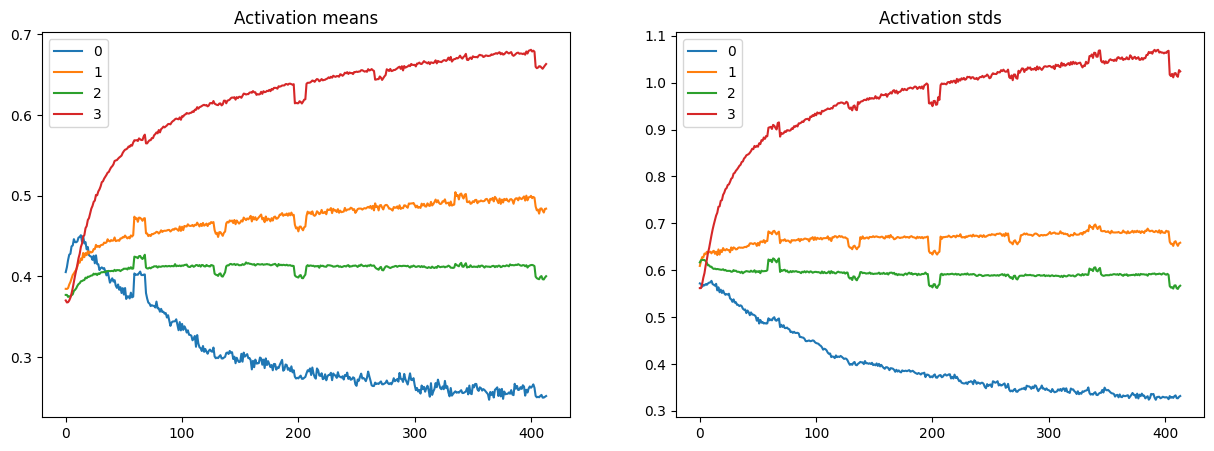

In [26]:
# Batch NormとKaiming初期化によりActivation層の分布は滑らかになっており、内部共変量シフトの問題がなくなっている
act_stats.plot_statistics()